<AxesSubplot:>

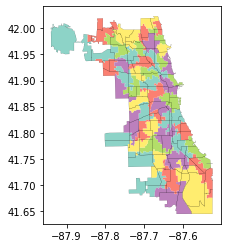

## Chicago Chain Runs
#### 50 Wards Out Of Precincts

This notebook performs the following chain run:
- Out of precincts:
    - 50 wards of equal population
        - Population deviation tolerance of 5%

In [400]:
from collections import defaultdict
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
import pathlib
import glob
import numpy as np

from gerrychain.random import random
import gerrychain as gc
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom
from gerrychain import accept
from gerrychain.tree import bipartition_tree, predecessors, random_spanning_tree
import json

# pd.set_option('display.max_columns', None)

In [547]:
ca_df = geopandas.read_file("../shapefiles/chicago_comareas_economic.shp").set_index("area_num_1")
df = geopandas.read_file("../shapefiles/chicago_precincts_economic.shp").set_index("JOINID")
df = df.join((geopandas.sjoin(df, ca_df, how="inner",lsuffix="left",rsuffix="right")[["community"]]),how="left").drop_duplicates(subset=["full_text"])

In [548]:
# Create the graph
# df = geopandas.read_file("../shapefiles/chicago_precincts_economic.shp").set_index("JOINID")
alder_precincts = pd.read_csv("../shapefiles/alder-precincts.tsv",sep="\t").set_index("Precinct")
df = df.join(alder_precincts[["Alderperson"]])
precincts = gc.Graph.from_geodataframe(df, reproject=False)
precincts.add_data(df)

In [529]:
alder_dict = alder_precincts.set_index("WARD").to_dict()['Alderperson']
# max is a cheap way to group by to find count, because precincts are one-indexed and increase by one presumably with no gaps...
total_precincts_dict = df[["precinct","ward"]].groupby("ward").max().to_dict()['precinct']
precincts_by_alder = {alder_dict[k]:v for (k,v) in total_precincts_dict.items()}
# print(list(alder_dict.values()) + ["Alderperson"])

In [530]:
partition = gc.Partition(precincts, assignment=df.ward)

In [549]:
votes_2019 = geopandas.read_file("../shapefiles/municipal_general_2019.geojson")
votes_2019["JOINID"] = votes_2019[["WARD","PRECINCT"]].apply(lambda x: f"C{x[0]:02}{x[1]:03}",axis=1)
votes_2019 = votes_2019.set_index("JOINID")
dontcares = ["PRECINCT","JERRY JOYCE","PAUL VALLAS","WILLIE L. WILSON","TONI PRECKWINKLE","WILLIAM M. DALEY","GARRY MCCARTHY","GERY CHICO","SUSANA A. MENDOZA","AMARA ENYIA","LA SHAWN K. FORD","NEAL SALES-GRIFFIN","LORI LIGHTFOOT","ROBERT 'BOB' FIORETTI","JOHN KENNETH KOZLAR","REGISTERED VOTERS","BALLOTS CAST","geometry"]
votes_2019 = votes_2019.drop(columns=dontcares)
votes_2019["Alderperson"] = votes_2019["WARD"].map(alder_dict)
votes_2019 = votes_2019.drop(columns=["WARD"])
pd.set_option('display.max_rows', 100)
votes_2019["winner_votes"] = votes_2019.apply(lambda x: x[x["Alderperson"]],axis=1)
votes_2019 = votes_2019.drop(columns=list(alder_dict.values()) + ["Alderperson"])
votes_2019["loser_votes"] = votes_2019.apply(lambda x: np.nanmax(x[:-1]),axis=1)
votes_2019["margin_2019_general"] = votes_2019["winner_votes"] - votes_2019["loser_votes"]
df = df.join(votes_2019[["margin_2019_general"]])

## Generating a seed plan with < 5% deviation

In [199]:
def recursive_tree_part(graph, parts, pop_col, epsilon, node_repeats=18):
    """Uses :func:`~gerrychain.tree_methods.bipartition_tree` recursively to partition a tree into
    ``len(parts)`` parts of population ``pop_target`` (within ``epsilon``). Can be used to
    generate initial seed plans or to implement ReCom-like "merge walk" proposals.
    :param graph: The graph
    :param parts: Iterable of part labels (like ``[0,1,2]`` or ``range(4)``
    :param pop_target: Target population for each part of the partition
    :param pop_col: Node attribute key holding population data
    :param epsilon: How far (as a percentage of ``pop_target``) from ``pop_target`` the parts
        of the partition can be
    :param node_repeats: Parameter for :func:`~gerrychain.tree_methods.bipartition_tree` to use.
    :return: New assignments for the nodes of ``graph``.
    :rtype: dict
    """
    flips = {}
    remaining_nodes = set(graph.nodes)
    
    total_pop = sum(graph.nodes[node][pop_col] for node in graph)
    remaining_pop = total_pop
    ideal_pop = total_pop / len(parts)
    pop_target = ideal_pop
    initial_epsilon = epsilon
    
    for i, part in enumerate(parts[:-1]):
        pop_target = remaining_pop / (len(parts) - i)
        nodes = bipartition_tree(
            graph.subgraph(remaining_nodes), pop_col, pop_target, epsilon, node_repeats
        )

        for node in nodes:
            flips[node] = part
        remaining_pop -= sum(graph.nodes[node][pop_col] for node in nodes)
        remaining_nodes -= nodes

    # All of the remaining nodes go in the last part
    for node in remaining_nodes:
        flips[node] = parts[-1]

    return flips

In [200]:
# Create an initial plan that does not violate population constraints
num_partitions = 50
pop_col = "TOTPOP"

# This modified recursive_tree_part manages to get below 5% deviation if
# you ask for 3%
assignment = recursive_tree_part(
    precincts,
    parts=range(num_partitions),
    pop_col=pop_col,
    epsilon=0.025,
)

In [13]:
# with open("./prec50/initial_assignment.json", "w") as f:
#     json.dump(assignment, f)

## Running the chain

In [18]:
with open("./prec50/initial_assignment.json") as f:
    assignment = json.load(f)

In [91]:
def alders_in_this_ward(partition):
    alders = defaultdict(list)
    for index, row in alder_precincts.iterrows():
        new_ward = partition.assignment[index]
        alders[new_ward].append(row[1])
    return alders

In [201]:
# Create an election object and updaters
# election = gc.Election("M15", ["Emanuel_M1", "Wilson_M15", "Fioretti_M", "Garcia_M15", "Walls_M15"])

updaters = {"population": gc.updaters.Tally("TOTPOP", alias="population"), "cut_edges": gc.updaters.cut_edges, "incumbents": alders_in_this_ward}

variables = [
    "TOTPOP", "HISP", "NH_WHITE", "NH_BLACK", "NH_ASIAN",
    "VAP", "HVAP", "WVAP", "BVAP", "ASIANVAP",'TOTHH', 'LESS_10K', '10K_15K', '15K_20K', '20K_25K',
       '25K_30K', '30K_35K', '35K_40K', '40K_45K', '45K_50K', '50K_60K',
       '60K_75K', '75K_100K', '100K_125K', '125K_150K', '150K_200K',
       '200K_MORE'
]
attrs = {key: gc.updaters.Tally(key, alias=key) for key in variables}
updaters.update(attrs)

# Create an initial partition
initial = gc.Partition(
    precincts,
    assignment=assignment,
    updaters=updaters
)

In [419]:
"""
a map has (x,y) community cohesion if for every ward, either a single community area contributes >= x% of the population of that ward,
or that ward contributes >= y% of its population to an individual community area.
e.g. (60, 60) would mean that 60% of (some CA) is in that ward, or 60% of that ward is in (some CA)

first is a ward's "largest contributor", second is a ward's "largest contribution"

This approach might balkanize a specific community area - the challenge is that community areas have such widely varying populations, e.g. west town or logan, that there's no way to keep them cohesive within a given ward, and making sure that every ward contributes or is contributed to seems to get close.

NYI:
How might you quantify / minimize balkanization? contributions to individual community areas below X% cannot account for Y% of its total area? so like, you don't want a CA to have 15%, 15%, 15%, 15% - for (20,50) balkanization, this would be unacceptable because then 60% of the CA's population comes from minority contributions to other wards, likely causing lack of cohesive govt for that CA.

maybe a bit more simply: for all CAs, there must be one ward contributing at least X% of that CA's total population, so like at least 35% of a CA is represented by an individual alder.
"""
def proportions(initial):
    ca_populations = defaultdict(int)
    ward_populations = defaultdict(int)
    ca_proportions = defaultdict(lambda: defaultdict(int))
    ward_proportions = defaultdict(lambda: defaultdict(int))
    for node in initial.graph.nodes:
        this_precinct_ca = initial.graph.nodes[node]["community"]
        this_precinct_ward = initial.assignment[node]
        this_precinct_population = initial.graph.nodes[node]["TOTPOP"]
        ca_populations[this_precinct_ca] += this_precinct_population
        ward_populations[this_precinct_ward] += this_precinct_population
    for node in initial.graph.nodes:
        this_precinct_ca = initial.graph.nodes[node]["community"]
        this_precinct_ward = initial.assignment[node]
        this_precinct_population = initial.graph.nodes[node]["TOTPOP"]
        ca_proportions[this_precinct_ca][this_precinct_ward] += this_precinct_population / ca_populations[this_precinct_ca]
        ward_proportions[this_precinct_ward][this_precinct_ca] += this_precinct_population / ward_populations[this_precinct_ward]
    proportions = defaultdict(dict)
    for neighborhood, val in ca_proportions.items():
        for ward, proportion in val.items():
            if proportions[ward].get("contribution") == None or proportion > proportions[ward]["contribution"][1]:
                proportions[ward]["contribution"] = (neighborhood, proportion)
    for ward, val in ward_proportions.items():
        for neighborhood, proportion in val.items():
            if proportions[ward].get("contributor") == None or proportion > proportions[ward]["contributor"][1]:
                proportions[ward]["contributor"] = (neighborhood, proportion)
    return proportions

def cohesion(partition):
    """
    This is a "symmetric" cohesion metric - it finds the smallest proportion
    for which every ward either contributes at least that much OR takes that
    much of a contribution from a given CA.
    """
    lowest_high_val = 100
    for key, val in partition["proportions"].items():
        high = max(val['contribution'][1], val['contributor'][1])
        lowest_high_val = min(lowest_high_val,high)
    return lowest_high_val

def cohesion_constraint(x,y, partition):
    """
    If you wanted to restrict drawn maps to be of a given cohesion,
    you could create a partial(cohesion_constraint,x,y) application
    and set it as a constraint.
    """
    retval = True
    for key, val in partition["proportions"].items():
        if val['contribution'][1] >= x or val['contributor'][1] >= y:
            continue
        else:
            # print(f"unsatisfied: {key}'s largest contribution is {val['contribution'][0]} at {val['contribution'][1]} (needs {x}) and " +
            #     f"{key}'s largest contributor is {val['contributor'][0]} at {val['contributor'][1]} (needs {y})")
            retval = False
    return retval

updaters["proportions"] = proportions
updaters["cohesion"] = cohesion

## Incumbent margin
* Each new district will have 0 or more incumbents drawn into it by home precinct.
* For each of those incumbents, some number of "above median" vote margin precincts will be drawn into that new ward.
* to compute this %, we need: # of above average precincts per incumbent, plus total # of above median precincts (to compute %)
* It might _also_ be useful to tweak whether this is above median, or above average, or top 75th percentile - generally, name recognition goes a long way and if an alder has been getting their name out there for the last 4 years, they might be better off than having a completely foreign precinct.


new columns:
name of incumbent
percentile of margin


In [540]:
temp_df = df[["ward","margin_2019_general"]].groupby("ward")["margin_2019_general"].apply(list).reset_index(name="new")
temp_df["margin_sorted"] = temp_df.apply(lambda x: sorted(x[1]),axis=1)
temp_df = temp_df.drop("new",axis=1)
temp_df["margin_percentile"] = temp_df.apply(lambda x: [y / len(x[1]) for y in range(len(x[1]))],axis=1)
temp_df["margin_percentile_map"] = temp_df.apply(lambda x: {x[1][y]:x[2][y] for y in range(len(x[1]))},axis=1)
temp_df = df[["full_text","ward","margin_2019_general"]].merge(temp_df,on="ward")
temp_df["incumbent_margin_2019_percentile"] = temp_df.apply(lambda x: x[5][x[2]] if not pd.isna(x[2]) else 0,axis=1)
new_df = pd.concat([df,temp_df[["incumbent_margin_2019_percentile"]]],ignore_index=True,axis=1)

In [554]:
df["incumbent_margin_2019_percentile"] = temp_df["incumbent_margin_2019_percentile"].tolist()

,full_text,precinct,shape_area,shape_len,ward,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,H_WHITE,H_BLACK,H_AMIN,H_ASIAN,H_NHPI,H_OTHER,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,TOTHH,LESS_10K,10K_15K,15K_20K,20K_25K,25K_30K,30K_35K,35K_40K,40K_45K,45K_50K,50K_60K,60K_75K,75K_100K,100K_125K,125K_150K,150K_200K,200K_MORE,geometry,community,Alderperson,margin_2019_general,incumbent_margin_2019_percentile
JOINID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C01001,01001,1.0,1.705171e+06,5225.758867,1.0,1410.000058,373.000020,111.999998,3.000001,18.000003,0.0,1.000000e+00,8.000001,895.000033,347.000024,16.000000,1.200000e+01,0.000000,0.0,468.000008,5.200000e+01,1097.000049,640.000025,354.000021,79.999998,3.000001,17.000003,0.0,0.000000e+00,3.000001,504.000015,61.999997,18.000000,21.000001,26.999999,0.000003,26.999997,13.000002,20.000000,4.999999e+01,18.000005,42.000000,49.000008,47.000004,57.999997,2.800000e+01,2.400000e+01,"POLYGON ((-87.69715 41.91567, -87.69714 41.915...",LOGAN SQUARE,NaN,52.0,0.431818
C01002,01002,2.0,1.484364e+06,4889.318839,1.0,1713.000082,200.999998,249.000046,3.000000,9.999997,0.0,8.000000e+00,14.999999,1227.000041,584.000015,24.000000,2.000000e+01,3.000000,0.0,526.000024,7.000000e+01,1160.000050,807.000028,185.000000,142.000026,2.000000,9.999997,0.0,5.000000e+00,8.999999,574.303578,35.475724,16.898523,42.492046,15.677244,37.939376,45.385512,14.034269,27.628987,2.310715e+01,39.593713,65.190483,87.483450,55.715376,19.396255,1.650928e+01,3.177619e+01,"POLYGON ((-87.71028 41.91685, -87.71024 41.915...",LOGAN SQUARE,NaN,47.0,0.386364
C01003,01003,3.0,1.373281e+06,5484.826007,1.0,1494.000018,945.999992,30.000001,0.000000,55.000003,0.0,1.000000e+00,25.000000,437.000023,162.000009,5.000000,1.000000e+01,1.000000,0.0,245.000017,1.400000e+01,1273.000011,307.000015,873.999993,25.000001,0.000000,50.000003,0.0,6.637132e-09,17.000000,662.776487,8.387826,28.701860,4.515150,8.274554,8.248004,10.184456,6.054577,18.237374,1.771167e+01,33.364266,44.555777,96.200229,65.240045,72.247386,9.143655e+01,1.494168e+02,"POLYGON ((-87.66742 41.90062, -87.66741 41.900...",WEST TOWN,NaN,84.0,0.636364
C01004,01004,4.0,1.491992e+06,6351.763672,1.0,1449.000038,790.000026,26.000001,1.000000,51.000003,2.0,3.000000e+00,17.999999,558.000008,233.000003,2.000001,3.000000e+00,2.000000,0.0,298.000006,2.000000e+01,1191.000034,412.000008,697.000023,22.000001,1.000000,46.000002,2.0,1.000000e+00,9.999999,680.026753,22.770003,10.223193,13.236119,26.291224,14.707943,14.768621,10.052197,32.505908,8.592507e+00,36.087485,52.943389,87.092143,76.057866,49.962586,9.693517e+01,1.278004e+02,"POLYGON ((-87.66973 41.89603, -87.66972 41.895...",WEST TOWN,NaN,36.0,0.295455
C01005,01005,5.0,1.563866e+06,6309.458059,1.0,1258.999949,953.999958,75.999999,0.999999,48.999997,0.0,5.000000e+00,27.000000,146.999996,68.999998,8.000000,9.657497e-09,0.000000,0.0,56.999999,1.300000e+01,1112.999950,121.999997,865.999959,46.999999,0.999999,48.999997,0.0,5.000000e+00,23.000000,582.423665,24.115959,12.239372,9.529473,0.675163,3.484126,1.755423,3.839680,23.867362,3.375236e+01,23.665478,63.667272,84.605913,57.512563,22.600488,8.297161e+01,1.341414e+02,"POLYGON ((-87.67467 41.90549, -87.67451 41.905...",WEST TOWN,NaN,65.0,0.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C50036,50036,36.0,1.982144e+06,6308.647940,50.0,1701.000001,792.999999,134.999998,5.000000,367.999999,0.0,2.562938e-08,47.999997,352.000008,149.000009,3.000000,1.000000e+00,1.000000,0.0,175.999999,2.200000e+01,1199.000002,202.000004,613.000001,75.999999,3.000000,273.999998,0.0,2.050350e-08,30.999998,528.003181,42.913335,10.561361,23.915580,15.766290,13.952452,64.361362,39.727004,27.137910,3.413292e+01,17.440504,46.873625,27.315891,17.750955,58.162430,3.394289e+01,5.404867e+01,"POLYGON ((-

In [559]:
alder_dict[df.loc["C50040",:]['ward']]

'DEBRA L. SILVERSTEIN'

In [560]:
# for node in initial.graph.nodes:
#     if not pd.isna(initial.graph.nodes[node]["Alderperson"]):
#         print(str(initial.graph.nodes[node]["Alderperson"]) + " lives in new ward " + str(initial.assignment[node]))

# first stab: find number of above-median 
incumbency_advantage = defaultdict(float)
for ward in initial["incumbents"].keys():
    for incumbent in initial["incumbents"][ward]:
        for idx in initial.parts[ward]:
            if incumbent == alder_dict[df.loc[idx,:]['ward']]:
                if df.loc[idx,:]['incumbent_margin_2019_percentile'] > .5:
                    # print(f"check {idx} if incumbent was {incumbent}, if so if num-above-percentile then increment counter by 1 / {precincts_by_alder[incumbent]/2}")
                    incumbency_advantage[incumbent] += 1/(precincts_by_alder[incumbent]/2)
print(incumbency_advantage)
# initial["incumbents"][1]


 C30012 if incumbent was ARIEL E. REBOYRAS, if so if num-above-percentile then increment counter by 1 / 16.0
check C30006 if incumbent was ARIEL E. REBOYRAS, if so if num-above-percentile then increment counter by 1 / 16.0
check C30002 if incumbent was ARIEL E. REBOYRAS, if so if num-above-percentile then increment counter by 1 / 16.0
check C31020 if incumbent was FELIX CARDONA JR., if so if num-above-percentile then increment counter by 1 / 20.5
check C31024 if incumbent was FELIX CARDONA JR., if so if num-above-percentile then increment counter by 1 / 20.5
check C31025 if incumbent was FELIX CARDONA JR., if so if num-above-percentile then increment counter by 1 / 20.5
check C31037 if incumbent was FELIX CARDONA JR., if so if num-above-percentile then increment counter by 1 / 20.5
check C31017 if incumbent was FELIX CARDONA JR., if so if num-above-percentile then increment counter by 1 / 20.5
check C31031 if incumbent was FELIX CARDONA JR., if so if num-above-percentile then increment

In [420]:
# needs_half = partial(cohesion,.45, .45)
assignment = recursive_tree_part(
precincts,
parts=range(num_partitions),
pop_col=pop_col,
epsilon=0.025,)
initial = gc.Partition(
precincts,
assignment=assignment,
updaters=updaters
)

# cohesion(initial)
# if(needs_half(initial)):
#     print("found one")
#     break
# else: print()

<AxesSubplot:>

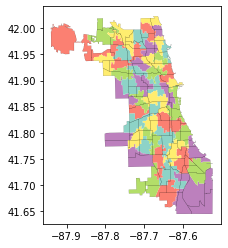

In [421]:
new_wards = geopandas.GeoDataFrame(
            {"assignment": initial.assignment.to_series()}, geometry=df.geometry).dissolve(by=assignment)
new_wards['greedy'] = greedy(new_wards)
base = new_wards.plot('greedy',categorical=True,cmap="Set3")
# draw community area boundaries on top of the new ward coloring
ca_df.plot(color="none",edgecolor="black",linewidth=.1,ax=base)

In [16]:
max(map(abs, gc.constraints.validity.deviation_from_ideal(initial).values()))

0.02624984663171423

In [119]:
pop_target = df.TOTPOP.sum() / 50
pop_col = "TOTPOP"

In [120]:
# Configure the ReCom proposal and constraints
proposal_50 = partial(recom,
                      pop_col=pop_col,
                      pop_target=pop_target,
                      epsilon=0.05,
                      node_repeats=10)

compactness_bound = gc.constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2 * len(initial["cut_edges"]))

population_constraint = gc.constraints.within_percent_of_ideal_population(initial, 0.05)

In [121]:
# Configure the Markov Chain
prec_chain50 = gc.MarkovChain(
    proposal=proposal_50,
    constraints=[compactness_bound, population_constraint],
    accept=accept.always_accept,
    initial_state=initial,
    total_steps=100_000)

ValueError: The given initial_state is not valid according is_valid. The failed constraints were: LowerBound(<lambda> <= 5)

In [16]:
for i, partition in enumerate(tqdm(prec_chain50)):
    with open(f"./prec50_20pct_deviation/assignments/assignment{i}.json", "w") as f:
        json.dump(partition.assignment.to_dict(), f)

100%|██████████| 100000/100000 [52:03<00:00, 32.01it/s]


## Create results CSV

This CSV will have ward-level demographic information for each step of the chain.

In [29]:
def partitions(run, graph, updaters):
    for step in range(100_000):
        path = pathlib.Path(f"./{run}/assignments/assignment{step}.json")
        with open(path) as f:
            assignment = json.load(f)
        partition = gc.Partition(graph, assignment, updaters=updaters)
        yield step, partition

In [32]:
data = pd.DataFrame.from_records(
    ([step, ward] + [partition[variable][ward] for variable in variables] + [len(partition.cut_edges)]
    for step, partition in tqdm(partitions("prec50", precincts, updaters), total=100_000)
    for ward in partition.parts),
    columns=["step", "ward"] + variables + ["cut_edges"]
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [4:49:25<00:00,  5.81it/s]


In [33]:
data.to_csv("./prec50/results.csv")

In [1]:
import requests